Importing the required libraries for calculations and plotting:

In [337]:
import numpy as np
import matplotlib.pyplot as plt

Writing all the function definitions required to perform the least squares approximation:

In [338]:
def construct_A(t: list, n: int) -> list:
    """Returns the interpolation matrix for given data points.

    Args:
        t (list): list of data points.
        n (int): degree of polynomial.

    Returns:
        list: list of list containing interpolation matrix.
    """
    A = []
    for i in range(len(t)):
        row = [1]
        for j in range(1, n+1):
            row.append(t[i]**j)
        A.append(row)
    
    return A


In [339]:
def transpose(given_matrix: list) -> list:
    """Returns transpose of given matrix.

    Args:
        given_matrix (list): list of list with row vectors as elements.

    Returns:
        list: list of list with column vectors as elements.
    """
    m = len(given_matrix)   # number of rows
    n = len(given_matrix[0])    # number of columns
    matrix_transpose = []
    for i in range(n):
        row = []
        for element in given_matrix:
            row.append(element[i])
        
        matrix_transpose.append(row)
    
    return matrix_transpose


In [340]:
def backward_sub(R: list, b: list) -> list:
    """Performs backward substitution to solve Rx=b.

    Args:
        R (list): list of list with column vectors as elements of a upper triangular matrix.
        b (list): column vector as a list.

    Returns:
        list: list containing solution of Rx=b.
    """
    m = len(R)
    x = [0 for _ in range(m)]
    x[m-1] = b[m-1]/R[m-1][m-1]

    for j in range(m-1, -1, -1):
        sum = 0
        for k in range(j+1, m):
            sum += x[k] * R[j][k]
        
        x[j] = (b[j] - sum)/R[j][j]
    
    return x



In [341]:
def estimate_polynomial(A: list, x: list) -> list:
    """Returns the polynomial from the coefficient vector x and interpolation matrix A.

    Args:
        A (list): interpolation matrix.
        x (list): coefficient vector.

    Returns:
        list: list containing polynomial.
    """
    no_of_points = len(A)
    y = []
    for i in range(no_of_points):
        y.append(np.dot(A[i], x))

    return y



In [342]:
def modified_gram_schmidt(given_matrix: list) -> list:
    """Performs Q, R factorization of given matrix using modified Gram Schmidt algorithm.

    Args:
        given_matrix (np.matrix): list of list with column vectors as elements.

    Returns:
        np.matrix: list containing Q and R matrices.
    """
    given_matrix = transpose(given_matrix)

    V = given_matrix.copy()
    n = len(V)
    R = np.zeros((n, n))
    Q_T = [[0 for i in range(len(given_matrix[0]))] for j in range(n)]

    for i in range(n):
        R[i][i] = np.linalg.norm(V[i], ord=2)
        if R[i][i] == 0:
            raise ValueError("Singular Matrix")
        Q_T[i] = V[i]/R[i][i]

        for j in range(i+1, n):
            R[i][j] = np.dot(Q_T[i], V[j])
            V[j] = V[j] - R[i][j]*Q_T[i]
    
    return Q_T, R


In [343]:

def householder_triangularization(given_matrix: list, b: list) -> list:
    """Performs QR factorization of given matrix using Householder triangularization.

    Args:
        given_matrix (list): list of list with row vectors as elements.
        b (list): RHS column vector as a list.

    Returns:
        list: list containing Q and R matrices.
    """
    # Using numpy arrays for ease of indexing and slicing 
    given_matrix = np.array(given_matrix)
    m, n = given_matrix.shape
    R = given_matrix.copy()
    Q = np.identity(m)
    reflect_mat = []

    for k in range(n):
        x = R[k:, k].copy()
        x[0] = x[0] + np.sign(x[0]) * np.linalg.norm(x, ord=2)
        x = x/np.linalg.norm(x, ord=2)

        house = np.identity(m)
        house[k:, k:] = house[k:, k:] - 2 * np.outer(x, x)
        reflect_mat.append(house)

        R = np.matmul(reflect_mat[k], R)
        Q = np.matmul(Q, reflect_mat[k])

    # Reduced QR factorization
    Q = Q[:, :n]
    R = R[:n, :]

    y = np.matmul(transpose(Q), b)
    x = backward_sub(R, y)
    return x


In [344]:
def least_sqr_mgs(A: list, b: list) -> list:
    """Returns least square solution of Ax=b using modified Gram Schmidt algorithm.

    Args:
        A (list): list of list with column vectors as elements.
        b (list): list of list with column vectors as elements.

    Returns:
        list: list containing least square solution.
    """
    Q_T, R = modified_gram_schmidt(A)
    y = np.matmul(Q_T, b)
    x = backward_sub(R, y)
    return x


In [345]:

def least_sqr_svd(given_matrix: list, b: list) -> list:
    """Returns least square solution of Ax=b using SVD.

    Args:
        given_matrix (list): list of list with row vectors as elements.
        b (list): function values as a list.

    Returns:
        list: list containing least square solution.
    """

    u,s,v=np.linalg.svd(given_matrix,full_matrices=False)
    w = np.matmul(transpose(u),np.transpose(b))
    for i in range(len(w)):
        w[i] = w[i]/s[i]
    x2 = np.matmul(np.transpose(v),w)
    
    return x2

Defining the linear system and performing various least squares approximations:

In [346]:
# Defining the function and the data points
no_of_points = 100
degree_of_interpolation = 14
t = [i for i in np.arange(0, 1, 1/no_of_points)]
f_t = [np.sin(10 * x) for x in t]

# Constructing the interpolation matrix
A = construct_A(t, degree_of_interpolation)

# Evaluating np.linallg.lstsq as the true solution
x_true = np.linalg.lstsq(A, f_t, rcond=None)[0]
y_true = estimate_polynomial(A, x_true)
err_lstsq = np.abs(np.array(f_t) - np.array(y_true))


In [347]:
# Modified Gram Schmidt method
x_mgs = least_sqr_mgs(A, f_t)
y_mgs = estimate_polynomial(A, x_mgs)
err_mgs = np.abs(np.array(y_true) - np.array(y_mgs))

In [348]:
# Householder triangularization method
x_house = householder_triangularization(A, f_t)
y_house = estimate_polynomial(A, x_house)
err_house = np.abs(np.array(y_true) - np.array(y_house))

In [349]:
# SVD method
x_svd = least_sqr_svd(A, f_t)
y_svd = estimate_polynomial(A, x_svd)
err_svd = np.abs(np.array(y_true) - np.array(y_svd))

In [350]:
# Normal equation (A.T A) x = (A.T) f_t
a_T_a = np.matmul(np.transpose(A), A)
b = np.matmul(np.transpose(A), f_t)
x_normal = np.linalg.solve(a_T_a, b)
y_normal = estimate_polynomial(A, x_normal)
err_normal = np.abs(np.array(y_true) - np.array(y_normal))

Comparison of "True" solution against the function values:

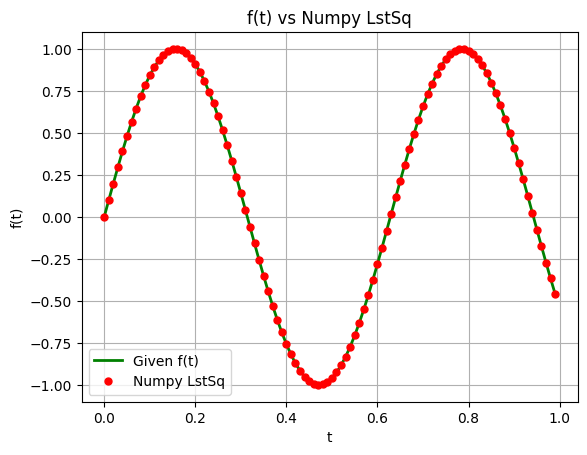

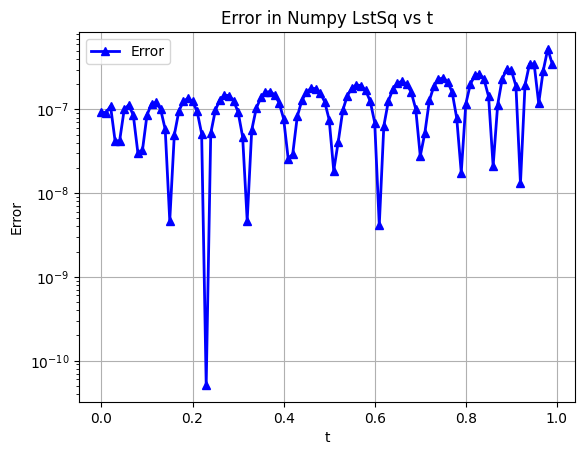

In [351]:
# Plot np.linalg.lstsq method vs function values
plt.plot(t, f_t, '-', label="Given f(t)", color="green", linewidth=2)
plt.plot(t, y_true, 'o', label="Numpy LstSq", color="red", markersize=5)
plt.xlabel("t")
plt.ylabel("f(t)")
plt.title("f(t) vs Numpy LstSq")  
plt.legend()
plt.grid()
plt.show()

# Plot the error between np.linalg.lstsq method and function values in log scale
plt.plot(t, err_lstsq, '^-', label="Error", color="blue", linewidth=2)
plt.xlabel("t")
plt.ylabel("Error")
plt.title("Error in Numpy LstSq vs t")
plt.yscale("log")
plt.legend()
plt.grid()
plt.show()


From the plots above, it can be seen that the obtained least squares solution from the inbuilt function agrees with the function values with the around 6-7 decimal precision in the worst case. As given in the question, this solution will be treated as the true solution to which the solutions from the other four algorithms will be compared to.

Comparison of the error between the four methods and the "True" solution:

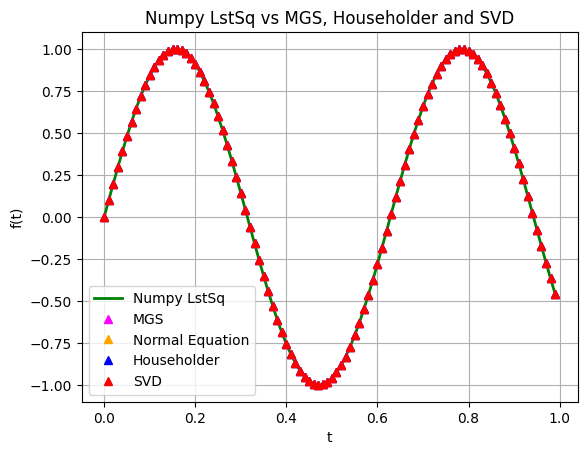

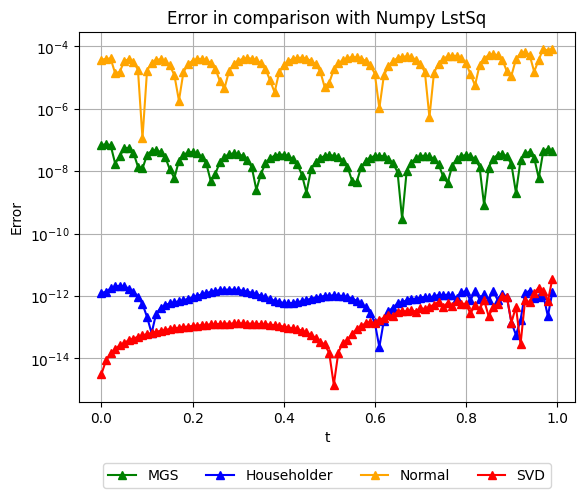

In [362]:
# Plotting the data points and the polynomial obtained using least square approximation
plt.plot(t, y_true, '-', label="Numpy LstSq", color="green", linewidth=2)
plt.plot(t, y_mgs, '^', label="MGS", color="magenta")
plt.plot(t, y_normal, '^', label="Normal Equation", color="orange")   
plt.plot(t, y_house, '^', label="Householder", color="blue")
plt.plot(t, y_svd, '^', label="SVD", color="red") 
plt.xlabel("t")
plt.ylabel("f(t)")
plt.title("Numpy LstSq vs MGS, Householder and SVD")
plt.legend()
plt.grid()
plt.show()


# Comparing the errors in log scale
plt.semilogy(t, err_mgs, '^-', label="MGS", color="green")
plt.semilogy(t, err_house, '^-', label="Householder", color="blue")
plt.semilogy(t, err_normal, '^-', label="Normal", color="orange")
plt.semilogy(t, err_svd, '^-', label="SVD", color="red")
plt.xlabel("t")
plt.ylabel("Error")
plt.title("Error in comparison with Numpy LstSq")
plt.grid()
plt.legend(bbox_to_anchor =(0.5,-0.2), loc='center', ncol=4)
plt.show()

Although the actual values as seen from the plot may seem to agree with the true solution for all four algorithms, that is not the case as depicted by the error plots. 

This semilog plot reveals the nuances to the accuracy of each of the algorithms. Firstly, SVD and Householder algorithms match up to 12-14 decimal points with the true solution. This could mean that the numpy impplementation of least squares using numpy.linalg.lstsq may use SVD as it also returns the singular values of the interpolation matrix. The householder and SVD algorithms of arriving at the least squares solution seem to have the very close orders of accuracy.

The MGS algorithm ranks as the next most accurate algorithm as it loses some orthogonality in Q when compared with Householder's triangularization algorithm. Since the algorithm involves explicit use of Q.T b and back substitution with the R matrix, the accuracy will be more affected by the loss of orthogonality than if we were to just compute A back using A = Q R.

The normal equation (A.T A) x = A.T b is solved exactly using np.linalg.solve() module. This is a bad way to solve the problem as the conditioning of the matrix (A.T A) is very bad, in the order of 1e18. This is because the matrix (A.T A) is close to singularity. This is reflected in the accuracy of the solution as the agreement between true solution is only around 4 decimals.

Comparing the obtained solutions with f(t) and plotting the error:

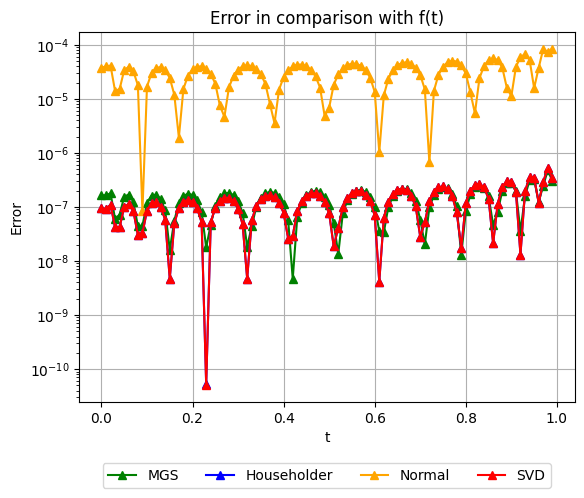

In [363]:
plt.plot(t, np.abs(np.array(f_t) - np.array(y_mgs)), '^-', label="MGS", color="green")
plt.plot(t, np.abs(np.array(f_t) - np.array(y_house)), '^-', label="Householder", color="blue")
plt.plot(t, np.abs(np.array(f_t) - np.array(y_normal)), '^-', label="Normal", color="orange")
plt.plot(t, np.abs(np.array(f_t) - np.array(y_svd)), '^-', label="SVD", color="red")
plt.yscale("log")
plt.xlabel("t")
plt.ylabel("Error")
plt.title("Error in comparison with f(t)")
plt.grid()
plt.legend(bbox_to_anchor =(0.5,-0.2), loc='center', ncol=4)
plt.show()

The arguments made using the comparison graph with the true solution are made evident in this comparison plot with f(t) itself. Clearly, for this polynomial interpolation, SVD and Householder are better than MGS which is in turn much better than the exact solution of normal equation.